In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

from src.config import c as gc
from src.generator import Generator

In [2]:
N = 128

In [3]:
# generate test data

g = Generator(
    csv_file=f"{gc['DATA_DIR']}/src/train.csv",
    images_src_dir=f"{gc['DATA_DIR']}/src/train_images",
    image_augmentation_options=None,
    shuffle=False,
)

_, y0 = g.get_one(0)

Y = np.zeros((N,) + y0.shape)
Y_noise = np.random.randn(*Y.shape)

for i in range(N):
    _, Y[i] = g.get_one(i)

In [17]:
def plot_loss_fn(loss_fn, Y, steps=100, f1_threshold=0.01):

    noise = np.random.uniform(0, 1, Y.shape)
    change_factor = np.arange(0.0, 1.0, 1.0 / steps)

    loss_v_noise = []
    loss_v_tozero = []
    loss_v_ones = [loss_fn(Y, np.ones_like(Y)).numpy()] * steps
    loss_v_zeros = [loss_fn(Y, np.zeros_like(Y)).numpy()] * steps
    metric_mean_f1 = []

    for i, f in enumerate(change_factor):
        # losses
        loss_v_noise.append(loss_fn(Y, Y * (1.0 - f) + noise * f).numpy())
        loss_v_tozero.append(loss_fn(Y, Y * (1.0 - f)).numpy())

        # mean f1 metric
        m = keras.metrics.Precision(thresholds=f1_threshold)
        m.update_state(Y, Y * (1.0 - f) + noise * f)
        m_p = m.result().numpy()
        m = keras.metrics.Recall(thresholds=f1_threshold)
        m.update_state(Y, Y * (1.0 - f) + noise * f)
        m_r = m.result().numpy()
        metric_mean_f1.append(2 * (m_p * m_r) / (m_r + m_p))

    plt.title(loss_fn.name)
    plt.xlabel("change factor")
    plt.ylabel("loss")
    plt.plot(change_factor, loss_v_noise)
    plt.plot(change_factor, loss_v_tozero)
    #     plt.plot(change_factor, loss_v_zeros)
    #     plt.plot(change_factor, loss_v_ones)
    plt.plot(change_factor, metric_mean_f1)
    plt.legend(
        [
            "truth —> uniform noise (0..1)",
            "truth —> zeros",
            f"mean f1 (threshold={f1_threshold})",
        ]
    )

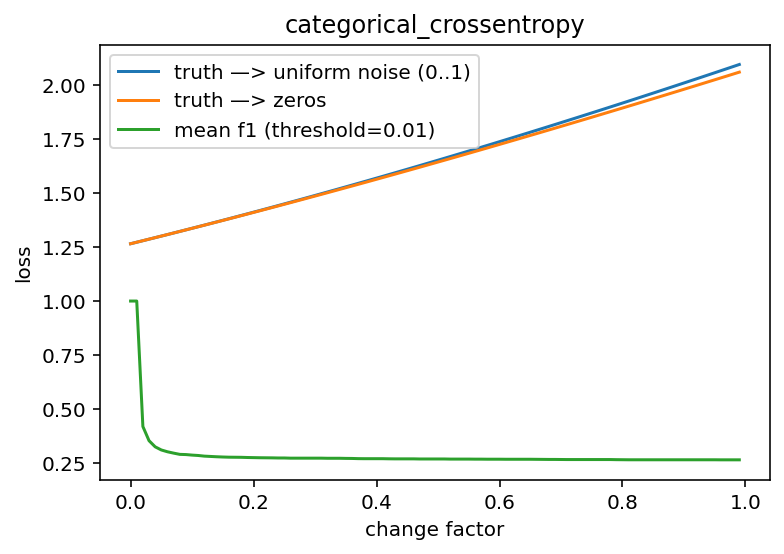

In [18]:
# CategoricalCrossentropy 1

plot_loss_fn(
    keras.losses.CategoricalCrossentropy(from_logits=True),
    Y,
)

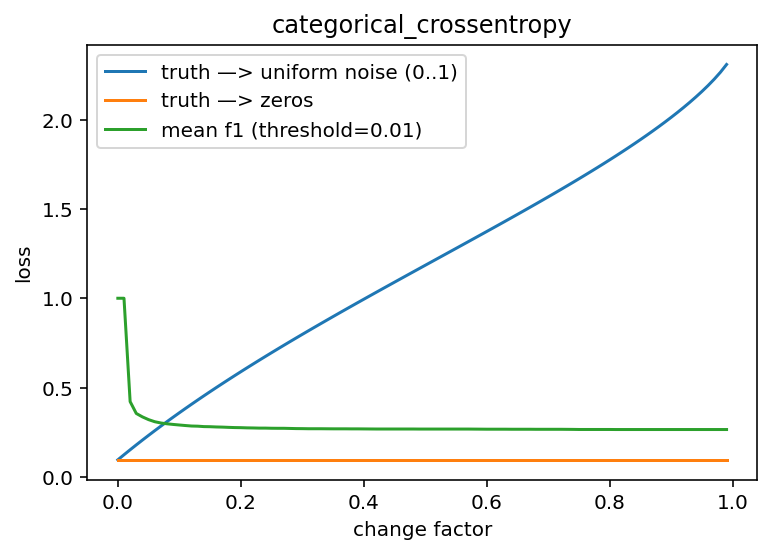

In [19]:
# CategoricalCrossentropy 2

plot_loss_fn(
    keras.losses.CategoricalCrossentropy(from_logits=False),
    Y,
)

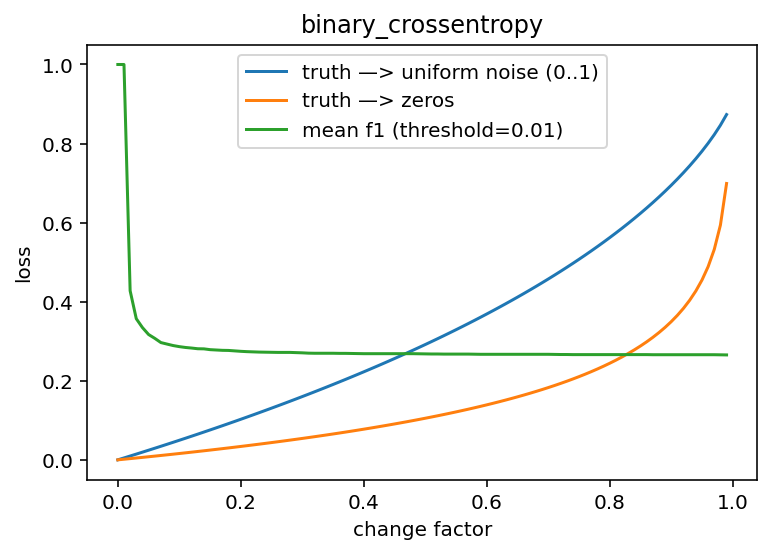

In [20]:
# BinaryCrossentropy

plot_loss_fn(
    keras.losses.BinaryCrossentropy(),
    Y,
)

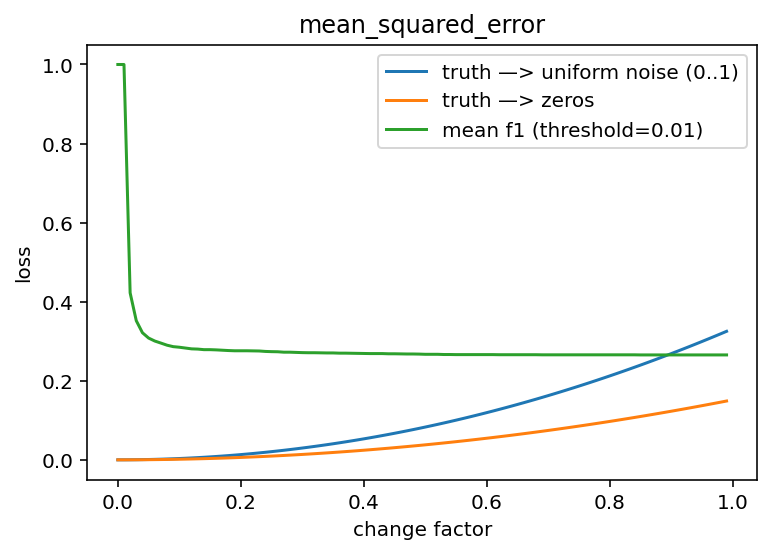

In [21]:
# MeanSquaredError

plot_loss_fn(
    keras.losses.MeanSquaredError(),
    Y,
)